# Overview
I have always loved debating basketball and the NBA. Many mornings I wake up and listen to Stephen A. Smith and Max Kellerman screaming at each other on ESPN First Take about which team will ultimately win the NBA Championship every year. Every April is especially fun when I would make bets with friends and family to support season-long arguements about who will win the title, right before the playoffs begin. This year, the playoffs didn't come in April, but after a long two months of suspension due to COVID-19, I was incredibly excited when the league announced the return of the season in July. Since the restart is still a couple weeks away,

###### I wanted to create a machine learning project to predict this year's NBA Champion based solely off regular season team stats  and to understand which regular season league rankings are the most important to determine playoff success.

# Data Collection
I decided to scrape https://www.basketball-reference.com/leagues/ with Beautiful Soup for playoff teams' regular season team stat league rankings from the 2003-2004 to 2018-2019 seasons (ex. regular season field goal percentage, total rebounds per game, etc.). League rankings show a relative picture of each team's strengths and weaknesses compared to the rest of the league in a given season going into the playoffs. I did not include actual per game numbers since the nature of the game has changed so much throughout recent years as playstyle, strategies, pace, etc. have skewed numbers like points per game higher than in the past, and comparing the actual numbers across different seasons would give a less accurate representation of the importance of each category to the model.

League rankings are numbered 1-30 since there are 30 total teams: a league rank of 1 being the best, 30 being the worst. I did not scrape older seasons since the playoff structure was changed in 2004 so that an NBA Championship must consist of winning 4 best of 7 game series, whereas prior seasons did not. The web scraper file is separate from this notebook.

In [440]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn import linear_model

In [441]:
data = pd.read_csv('/Users/trustin/Desktop/data_sci/projects/nba_chip_pred/past_league_rankings.csv')
pred_data = pd.read_csv('/Users/trustin/Desktop/data_sci/projects/nba_chip_pred/2020_league_rankings_before_orlando.csv')
data.head()

,Rk,Team,Year,Playoff Wins,MP,FG,FGA,FG%,3P,3PA,...,eFG%,TOV%,ORB%,FT/FGA,eFG%.1,TOV%.1,DRB%,FT/FGA.1,Arena,Attendance
0,1,San Antonio Spurs,2003,16,14,16,27,4,11,11,...,4,24,13,6,2,12,17,3,NaN,11
1,2,New Jersey Nets,2003,14,26,17,18,14,23,22,...,21,16,14,7,4,3,6,14,NaN,23
2,3,Dallas Mavericks,2003,10,24,3,2,7,2,2,...,3,1,27,20,15,9,19,10,NaN,3
3,4,Detroit Pistons,2003,8,5,26,28,24,6,6,...,14,9,24,9,5,15,1,15,NaN,1
4,5,Sacramento Kings,2003,7,14,1,1,3,7,9,...,2,6,26,29,1,18,21,5,NaN,12


# Data Cleaning

In [442]:
#inspecting the different team stat categories
data.columns

Index(['Rk', 'Team', 'Year', 'Playoff Wins', 'MP', 'FG', 'FGA', 'FG%', '3P',
       '3PA', '3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB',
       'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'O_MP', 'O_FG', 'O_FGA',
       'O_FG%', 'O_3P', 'O_3PA', 'O_3P%', 'O_2P', 'O_2PA', 'O_2P%', 'O_FT',
       'O_FTA', 'O_FT%', 'O_ORB', 'O_DRB', 'O_TRB', 'O_AST', 'O_STL', 'O_BLK',
       'O_TOV', 'O_PF', 'O_PTS', 'W', 'L', 'PW', 'PL', 'MOV', 'SOS', 'SRS',
       'ORtg', 'DRtg', 'Pace', 'FTr', '3PAr', 'eFG%', 'TOV%', 'ORB%', 'FT/FGA',
       'eFG%.1', 'TOV%.1', 'DRB%', 'FT/FGA.1', 'Arena', 'Attendance'],
      dtype='object')

### Dropping duplicative or irrelevant columns

In [443]:
data = data.drop(columns = ['Rk','O_MP','L','PW','PL','Arena']).rename(columns={'eFG%.1':'O_eFG%','TOV%.1':'O_TOV%','FT/FGA.1':'O_FT/FGA'})
pred_data = pred_data.drop(columns = ['Rk','O_MP','L','PW','PL','Arena']).rename(columns={'eFG%.1':'O_eFG%','TOV%.1':'O_TOV%','FT/FGA.1':'O_FT/FGA'})

Extracting relevant features for model: With many features to filter out but no categorical variables, I chose a correlation matrix as the most efficient way to find the most important X variables.

In [444]:
#finding variables that have a Pearson's Correlation Coefficient of at least medium strength with number of playoff wins
corr = data.corr().abs()
corr = corr.loc[corr['Playoff Wins']>.25]
corr.index

Index(['Playoff Wins', 'FG%', '3P%', '2P%', 'DRB', 'O_FG%', 'O_2P%', 'O_BLK',
       'W', 'MOV', 'SRS', 'ORtg', 'DRtg', 'eFG%', 'O_eFG%', 'Attendance'],
      dtype='object')

### Relationship between filtered features and number of playoff wins

Text(0.5, 14.09375, 'Regular Season Stat Rankings')

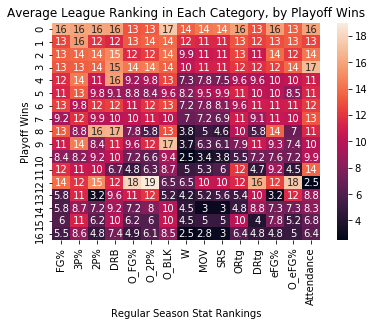

In [445]:
variables = list(corr.index)
corr_df = data[variables].groupby('Playoff Wins').mean()
corr_df
plt.title("Average League Ranking in Each Category, by Playoff Wins")
sns.heatmap(data=corr_df,annot=True)
plt.xlabel("Regular Season Stat Rankings")

Looking for stat categories where average league rankings are closer to 1 as playoff wins increase

### Checking for multicollinearity among filtered variables

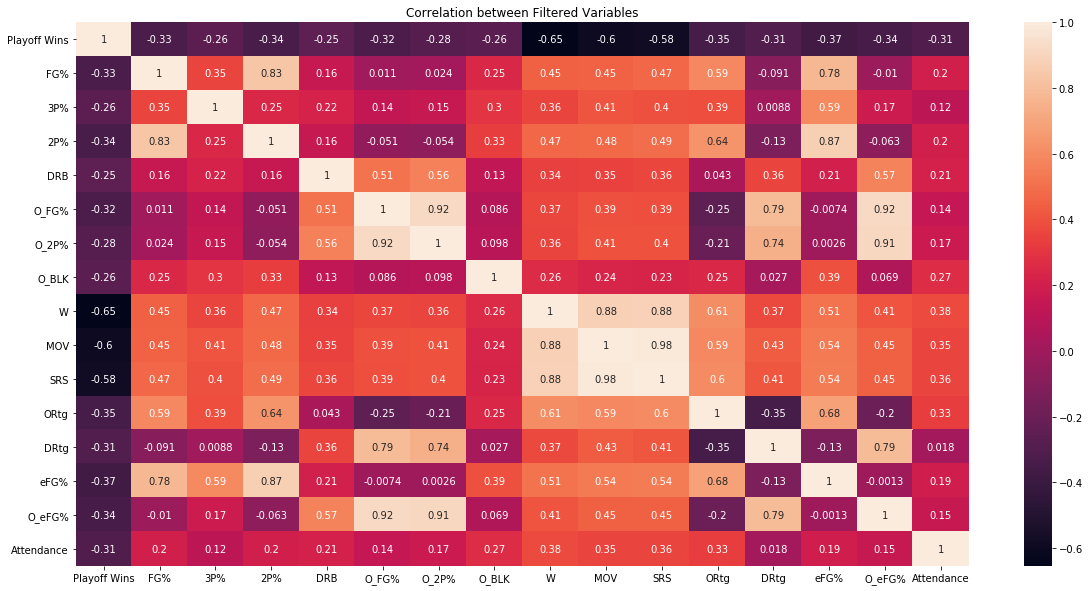

In [446]:
plt.figure(figsize=(20,10))
plt.title("Correlation between Filtered Variables")
sns.heatmap(data=data[variables].corr(), annot=True)

Being ranked in the top 3 for Regular Season Wins (W), Margin of Victory (MOV), and Simple Rating System (SRS) seem to be decent indicators of being able to predict the NBA Champion. However, SRS and MOV are highly correlated since point differential is used in calculating both. I decided to remove MOV since SRS is slightly more accurate in that it takes difficulty of season schedule into account. Attendance was also dropped since the remainder of the 2020 season will be played in Orlando's Disney World with no live crowds.

Text(0.5, 1.0, 'Correlation of Regular Season Shooting Efficiency and Playoff Wins')

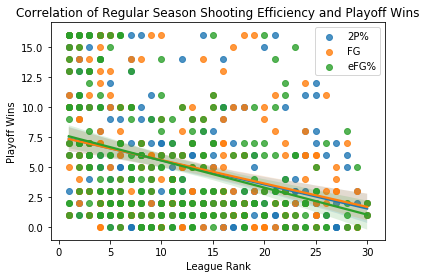

In [447]:
ax = sns.regplot(x=data['2P%'],y=data['Playoff Wins'],label='2P%')
sns.regplot(x=data['FG%'],y=data['Playoff Wins'],label='FG')
sns.regplot(x=data['eFG%'],y=data['Playoff Wins'],label='eFG%')
ax.set(xlabel="League Rank")
plt.legend()
plt.title("Correlation of Regular Season Shooting Efficiency and Playoff Wins")

Effective Field Goal Percentages (eFG% and O_eFG%) are highly correlated with their corresponding Field Goal Percentages(2P%, O_2P%, FG%, O_FG%), so I will take out the latter four since Effective Field Goal Percentages calculate a slightly more accurate rate of shooting efficiency. eFG% is also slightly more correlated with number of playoff wins as shown by the linear regressions above.

In [448]:
remove = ['MOV','2P%','O_2P%','FG%','O_FG%','Attendance']
variables = [item for item in variables if item not in remove]
variables

['Playoff Wins',
 '3P%',
 'DRB',
 'O_BLK',
 'W',
 'SRS',
 'ORtg',
 'DRtg',
 'eFG%',
 'O_eFG%']

# EDA

#### Opponent Blocks Per Game
I found the Opponent's Blocks (O_BLK) category to be the most interesting feature that is moderately correlated with playoff wins. This finding made me hypothesize that teams who rank in the top percentile in O_BLK give their opponents a more difficult time defending them, which equates to a greater win count. Additionally, the majority of blocks in basketball come from very short range shots, so teams whose opponents are less able to block shots are able to score much easier at a higher clip since there is a much higher probability of making a short range shot (ex. layup/dunk) vs a mid-range 2 or 3 pointer. I further explore the nature of O_BLK below.

Text(0.5, 1, 'Regular Season League Ranking of Blocks Allowed per Game')

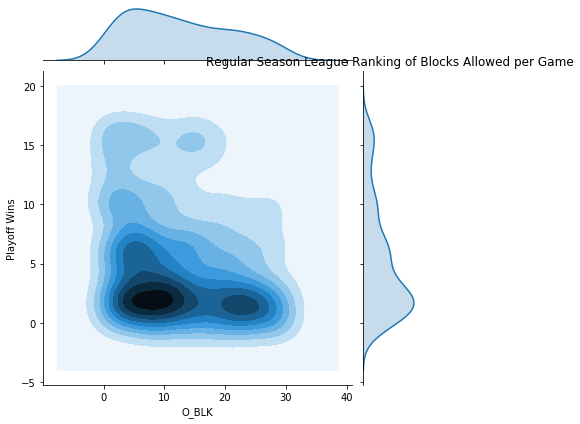

In [449]:
sns.jointplot(x=data['O_BLK'],y=data['Playoff Wins'],kind='kde')
plt.title("Regular Season League Ranking of Blocks Allowed per Game")

Teams ranked top 10 in limiting the amount of blocks their opponents get are more likely to win a higher number of playoff games

[Text(0, 0.5, 'eFG% League Rank'), Text(0.5, 0, 'O_BLK League Rank')]

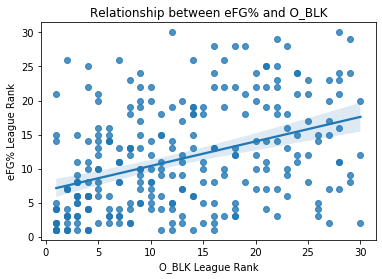

In [450]:
plt.title("Relationship between eFG% and O_BLK")
ax = sns.regplot(x=data['O_BLK'],y=data['eFG%'])
ax.set(xlabel="O_BLK League Rank", ylabel="eFG% League Rank")

Examining the relationship between a team's effective field goal percentage and the amount of blocks they allow per game

## Championship Team Regular Season League Rankings over Time
Now I wanted to group each selected variable into 3 major regular season stat categories that are good indicators of predicting the NBA Champion before the playoffs begin: Offense, Defense, Nature of Wins. Below are the three line graphs that show how a championship team's different regular season league rankings have trended over time.

### Offense

[Text(0, 0.5, 'Regular Season League Ranking')]

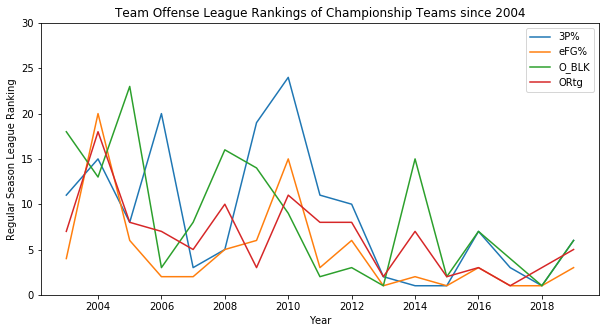

In [451]:
chip_years = data.loc[data['Playoff Wins']==16]

plt.figure(figsize=(10,5))
plt.title("Team Offense League Rankings of Championship Teams since 2004")
ax = sns.lineplot(x=chip_years.Year, y=chip_years['3P%'],label="3P%")
sns.lineplot(x=chip_years.Year, y=chip_years['eFG%'],label="eFG%")
sns.lineplot(x=chip_years.Year, y=chip_years['O_BLK'],label="O_BLK")
sns.lineplot(x=chip_years.Year, y=chip_years['ORtg'],label="ORtg")
plt.ylim(0, 30)
ax.set(ylabel="Regular Season League Ranking")

There is more variability in the 2000s than the 2010s in terms of a champion's regular season team offensive stats. The most interesting trend here is the 3P% as the Golden State Warriors have revolutionized basketball with shooting 3's since 2014. The 3 pointer has become the most important shot in the game due to its higher EV and ability to space the floor to create more open 2 point field goals. We see that generally, champions of recent years tend to be ranked in the top 5-10 for each offensive team stat and are generally ranked top 5 in 3P%.

### Defense

[Text(0, 0.5, 'Regular Season League Ranking')]

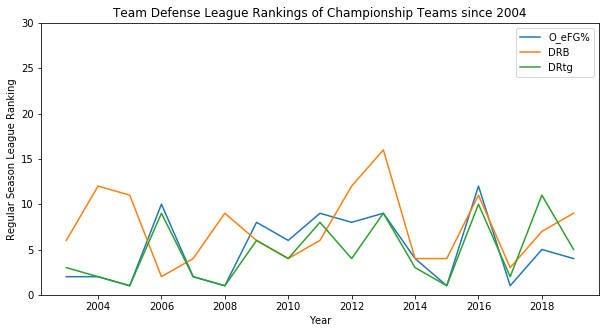

In [452]:
plt.figure(figsize=(10,5))
plt.title("Team Defense League Rankings of Championship Teams since 2004")
ax = sns.lineplot(x=chip_years.Year, y=chip_years['O_eFG%'],label="O_eFG%")
sns.lineplot(x=chip_years.Year, y=chip_years['DRB'],label="DRB")
sns.lineplot(x=chip_years.Year, y=chip_years['DRtg'],label="DRtg")
plt.ylim(0, 30)
ax.set(ylabel="Regular Season League Ranking")

Regular season team defense stat rankings seem to have much less variability than team offense stat rankings, and being ranked in the top 5-10 in these three categories can be a good indicator of a playoff champion. Defensive rebounding (DRB) is important, but slightly less important than limiting opponent field goal efficiency (O_eFG%) and overall defensive rating (DRtg).

### Nature of Wins

[Text(0, 0.5, 'Regular Season League Ranking')]

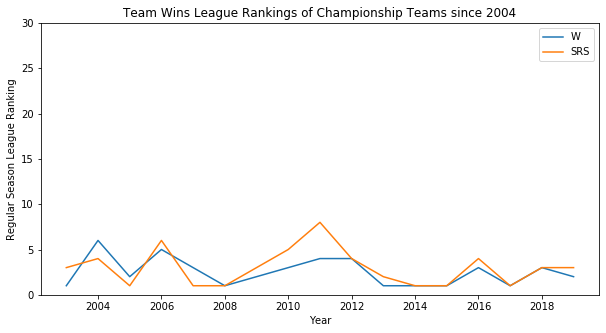

In [453]:
plt.figure(figsize=(10,5))
plt.title("Team Wins League Rankings of Championship Teams since 2004")
ax = sns.lineplot(x=chip_years.Year, y=chip_years['W'],label="W")
sns.lineplot(x=chip_years.Year, y=chip_years['SRS'],label="SRS")
plt.ylim(0, 30)
ax.set(ylabel="Regular Season League Ranking")

The amount of wins (W) and Simple Rating System (SRS) in the regular season seem to be the most consistent indicators of predicting a champion. It is rare for a championship team to rank outside the top 5 in number of regular season wins or SRS.

### Comparing Offensive Overall Rating, Defensive Overall Rating, and Win Count
Seeing every year's championship team's overall offensive league ranking, overall defensive league ranking, and regular season wins standing 

[Text(0, 0.5, 'Regular Season League Ranking')]

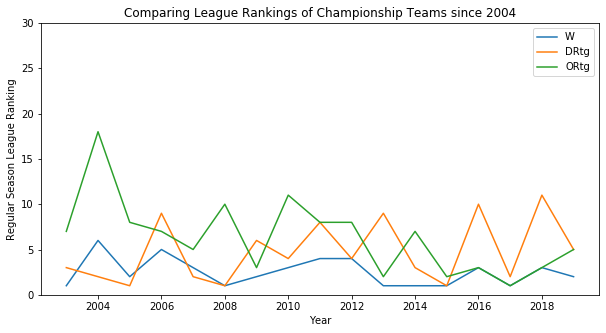

In [454]:
plt.figure(figsize=(10,5))
plt.title("Comparing League Rankings of Championship Teams since 2004")
ax = sns.lineplot(x=chip_years.Year, y=chip_years['W'],label="W")
sns.lineplot(x=chip_years.Year, y=chip_years['DRtg'],label="DRtg")
sns.lineplot(x=chip_years.Year, y=chip_years['ORtg'],label="ORtg")
plt.ylim(0, 30)
ax.set(ylabel="Regular Season League Ranking")

In recent years, overall offensive team rating has been higher than overall defensive rating

# Modeling

In [471]:
X = data[variables].drop('Playoff Wins',1)
y = data['Playoff Wins']

pred_X = pred_data[variables].drop('Playoff Wins',1)

X.head()

,3P%,DRB,O_BLK,W,SRS,ORtg,DRtg,eFG%,O_eFG%
0,11,6,18,1,3,7,3,4,2
1,22,12,19,8,4,18,1,21,4
2,3,9,3,1,1,1,9,3,15
3,8,18,5,5,5,15,4,14,5
4,4,1,6,3,2,6,2,2,1


In [472]:
#splitting data into training and testing sets
X_train, X_valid, y_train, y_valid = train_test_split(X,y)

## Linear Regression

In [473]:
lg_model = linear_model.LinearRegression()
lg_model.fit(X_train, y_train)
lg_model_predicted_wins = lg_model.predict(X_valid)
print("Mean Absolute Error: " + str(mean_absolute_error(lg_model_predicted_wins, y_valid)))

Mean Absolute Error: 2.6497752008879742


In [474]:
lg_model_predicted_wins = lg_model.predict(pred_X)
lg_model_predicted_wins

array([11.05911211,  8.81838556,  6.61628333,  6.83931241,  4.24488757,
        4.00093541,  1.91239745,  0.69529167, -4.91100431, 10.51240628,
        8.28910065,  7.13356774,  6.8274553 ,  5.87329748,  4.55753736,
        5.48341742,  1.9012651 , -0.5447735 , -0.62233103, -0.20304307,
       -2.25217802, -4.32344602])

### Linear Regression Predictions

In [475]:
lg_model_predicted_wins_df = pred_data[['Team','Playoff Wins']]
i=0
while i<22:
    lg_model_predicted_wins_df.at[i, 'Playoff Wins'] = lg_model_predicted_wins[i]
    i+=1
lg_model_predicted_wins_df.sort_values(by='Playoff Wins',ascending=False)

,Team,Playoff Wins
0,Milwaukee Bucks,11.059112
9,Los Angeles Lakers,10.512406
1,Toronto Raptors,8.818386
10,Los Angeles Clippers,8.289101
11,Denver Nuggets,7.133568
3,Miami Heat,6.839312
12,Utah Jazz,6.827455
2,Boston Celtics,6.616283
13,Oklahoma City Thunder,5.873297
15,Dallas Mavericks,5.483417


This linear regression model predicts the Bucks as the most likely to win the championship with the highest expected number of playoff wins. The Lakers, Raptors, and Clippers usually trail in the top 4 as well. Some teams in the bottom are actually projected to win a negative number of playoff games which is likely due to the fact that the data includes 22 teams instead of 16.

## Random Forest

In [476]:
#using cross validation score to build first model
from sklearn.model_selection import cross_val_score

def rfr_cvs(n_estimators,cv):
    model = RandomForestRegressor(n_estimators=n_estimators, random_state=0)
    scores = -1*cross_val_score(model,X,y,cv=cv,scoring='neg_mean_absolute_error')
    return "score = "+str(scores.mean())+" with n_estimators: "+str(n_estimators)+" and cv: "+str(cv)

In [477]:
#comparing cross validation scores across different numbers of trees and testing if 5 or 10 k-folds is optimal
#for n_estimators in np.arange(start=100,stop=400,step=50):
#    print(rfr_cvs(n_estimators,5))

In [478]:
#for n_estimators in np.arange(start=100,stop=400,step=50):
#    print(rfr_cvs(n_estimators,10))

A traditional 10-fold cross-validation with 350 trees in the Random Forest seems to be a decent starting model

In [479]:
rfr_model = RandomForestRegressor(n_estimators=350, random_state=0)
rfr_model.fit(X_train, y_train)
rfr_predicted_wins = rfr_model.predict(X_valid)
print("Mean Absolute Error: " + str(mean_absolute_error(rfr_predicted_wins, y_valid)))

Mean Absolute Error: 2.6464705882352946


In [480]:
rfr_predicted_wins = rfr_model.predict(pred_X)
rfr_predicted_wins

array([12.94857143,  9.46      ,  7.72      ,  6.62571429,  2.79428571,
        1.99714286,  1.97714286,  1.20571429,  2.54857143, 10.12571429,
        9.33714286,  5.47428571,  7.52571429,  3.56285714,  3.25714286,
        4.44      ,  1.78571429,  1.17428571,  2.68285714,  2.52285714,
        1.98      ,  2.12571429])

### Random Forest Predictions

In [481]:
rfr_predicted_wins_df = pred_data[['Team','Playoff Wins']]
i=0
while i<22:
    rfr_predicted_wins_df.at[i, 'Playoff Wins'] = rfr_predicted_wins[i]
    i+=1
rfr_predicted_wins_df.sort_values(by='Playoff Wins',ascending=False)

,Team,Playoff Wins
0,Milwaukee Bucks,12.948571
9,Los Angeles Lakers,10.125714
1,Toronto Raptors,9.460000
10,Los Angeles Clippers,9.337143
2,Boston Celtics,7.720000
12,Utah Jazz,7.525714
3,Miami Heat,6.625714
11,Denver Nuggets,5.474286
15,Dallas Mavericks,4.440000
13,Oklahoma City Thunder,3.562857


After resplitting the training and testing data over 50 times, the model consistently projects the Milwaukee Bucks to have the most playoff wins in the 2020 Playoffs. The Lakers, Raptors, and Clippers are consistently projected to be the next 3 best teams. The MAE in the Random Forest model ranges between 2 and 3 games, which means that the model is not too far off from predicting the amount of playoff wins for a given regular season team. The Random Forest's MAE has improved from the linear regression model's.

However, I decided to create another model with XGBoost to see if I can predict the champion with a smaller average MAE than with RandomForestRegressor.

## XGBoost

In [482]:
from xgboost import XGBRegressor

def xgb_cvs(n_estimators, learning_rate, cv):
    model = XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate)
    scores = -1*cross_val_score(model,X,y,cv=cv,scoring='neg_mean_absolute_error')
    return "score = "+str(scores.mean())+" with n_estimators: "+str(n_estimators)+" and cv: "+str(cv)

In [483]:
#for n_estimators in np.arange(start=100,stop=1000,step=100):
#    print(xgb_cvs(n_estimators,.05,10))

In [484]:
xgb_model = XGBRegressor(n_estimators=100,learning_rate=.05)
xgb_model.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_valid, y_valid)], verbose=False)
xgb_predicted_wins = xgb_model.predict(X_valid)
print("Mean Absolute Error: " + str(mean_absolute_error(xgb_predicted_wins, y_valid)))

Mean Absolute Error: 2.441409501082757


In [485]:
xgb_predicted_wins = xgb_model.predict(pred_X)
xgb_predicted_wins 

array([9.282978  , 7.0834646 , 4.771911  , 3.871493  , 1.2403437 ,
       0.9532484 , 0.93215895, 0.5446661 , 1.1391921 , 8.780715  ,
       7.733144  , 5.1079636 , 4.94113   , 2.79421   , 2.692216  ,
       4.319667  , 0.57120866, 0.78534216, 2.4495354 , 1.5296634 ,
       0.9675065 , 1.9284043 ], dtype=float32)

### XGBoost Predictions

In [486]:
xgb_predicted_wins_df = pred_data[['Team','Playoff Wins']]
i=0
while i<22:
    xgb_predicted_wins_df.at[i, 'Playoff Wins'] = xgb_predicted_wins[i]
    i+=1
xgb_predicted_wins_df.sort_values(by='Playoff Wins',ascending=False)

,Team,Playoff Wins
0,Milwaukee Bucks,9.282978
9,Los Angeles Lakers,8.780715
10,Los Angeles Clippers,7.733144
1,Toronto Raptors,7.083465
11,Denver Nuggets,5.107964
12,Utah Jazz,4.941130
2,Boston Celtics,4.771911
15,Dallas Mavericks,4.319667
3,Miami Heat,3.871493
13,Oklahoma City Thunder,2.794210


After resplitting the training and testing data over 50 times for both models, the XGBoost model tends to have more variability in determining the champion than the Random Forest. The model with lower MAE also varies upon each resplitting of the training and testing data, however both XGBoost and Random Forest consistently are better than the linear regression.

# Conclusion
## Limitations
My main concern with the data is that the sample size of championship teams (16 playoff wins) is very small. This means that the best team in each model will always have an expected win count less than 16 which is obviously not sufficient to win the title. However, I interpreted the scores as a relative scale to see which team has the highest predicted value of wins as the champion.

The models' MAE also varied upon each resplitting of test and train data. The values generally ranged between 2 and 3 for each model. I used the predictions and MAE's from a random trial for the summary findings.

## Summary
Using regular season stat league rankings, I found that being in the top league rankings of amount of Wins (W) and Simple Rating System (SRS) during the regular season are the best indicators of predicting the champion. In recent trends, a higher offensive rating than defensive rating has translated into a greater chance of winning the title as well.

The best prediction performance was achieved by the Random Forest Regressor with a MAE of 2.65, and projected the Bucks as favorites for the title with 13 expected wins. XGBoost had a smaller Mean Absolute Error of 2.44, however it predicted that the 1st place Bucks would only win 9.3 games which is far off from the 16 needed for a championship.

The Milwaukee Bucks were chosen by each model to be the favorite to win the title. The Lakers, Raptors, and Clippers are usually mixed in the standings behind the Bucks.

## Future Work
I plan to keep updating this dataset each year's champion and continue to refine the existing models and add new ones. There is a lot of room for improvement in the algorithms, parameters, and statistics I used considering this is my  first data science project with only 2 months of coding experience.